<h1><h1>Pre-trained-Models with PyTorch </h1>


The aim of this project is to to predict binary class of object using CV. The problem is to find damaged sections of the building walls by a photo.

<h2 id="download_data">Download Data</h2>


In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2022-03-08 07:18:55--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  32.9MB/s    in 74s     

2022-03-08 07:20:09 (33.6 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [ ]:
!unzip -q Positive_tensors.zip 

In [ ]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2022-03-08 07:22:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  33.6MB/s    in 66s     

2022-03-08 07:23:06 (30.4 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



We will install torchvision:


In [ ]:
!pip install torchvision

<h2 id="auxiliary">Imports</h2>


In [ ]:
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


This dataset class is aimed to speed things up, we are going to use tensors instead of jpeg images.

In [ ]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self, transform=None, train=True):

        positive = "Positive_tensors"
        negative = 'Negative_tensors'

        positive_file_path = './Positive_tensors'
        negative_file_path = './Negative_tensors'
        positive_files = [os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files = [os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples = len(positive_files) + len(negative_files)
        self.all_files = [None] * number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0
        
        if train:
            self.all_files = self.all_files[0:30000]
            self.Y = self.Y[0:30000]
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image = torch.load(self.all_files[idx])
        y = self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [ ]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


Download pretrained resnet18 model:

In [ ]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Set the attribute <code>requires_grad</code> to <code>False</code> because we do not want the parameters be affected by training.

In [ ]:
for param in model.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs.
We replace the output layer <code>model.fc</code> with <code>nn.Linear</code> object with 2 output layers.

In [ ]:
model.fc = nn.Linear(512, 2)

Print our model information:

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2>Train the Model</h2>


Create a cross entropy criterion function


In [ ]:
criterion = nn.CrossEntropyLoss()

Create a training loader and validation loader object, the batch size have 100 samples each

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=100
)

Adam optimizer

In [ ]:
optimizer = torch.optim.Adam(
    [parameters for parameters in model.parameters() if parameters.requires_grad],
    lr=0.001)

<!--Empty Space for separating topics-->


Training process with 1 epoch

In [ ]:
n_epochs = 1
loss_list = []
accuracy_list = []
correct = 0
N_test = len(validation_dataset)
N_train = len(train_dataset)
start_time = time.time()


Loss = 0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:

        model.train() 
        # clear gradient 
        optimizer.zero_grad()
        # make a prediction 
        z = model(x)
        # calculate loss 
        loss = criterion(z, y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()

        loss_list.append(loss.data)


    correct = 0
    for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        # make a prediction 
        z = model(x_test)
        # find max
        _, yhat = torch.max(z.data, 1)
        # Calculate misclassified  samples in mini-batch 
        # hint +=(yhat==y_test).sum().item()
        correct += (yhat == y_test).sum().item()
        
   
    accuracy = correct/N_test
    accuracy_list.append(accuracy)

print('Done. Time is', time.time() - start_time)

Done. Time is 3545.8813712596893


Accuracy

In [ ]:
accuracy

0.9941

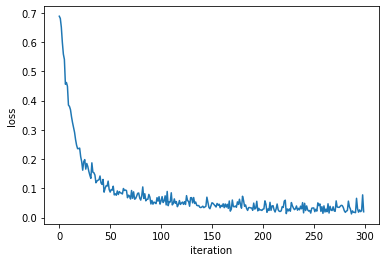

In [ ]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()
